### Pregunta de Negocio - Analistes de Finances i Risc Crediticio

> En quina **mesura** els clients amb **saldos més baixos** estan en **més risc d'incompliment de crèdit**, i com hem d'ajustar les nostres polítiques de crèdit per mitigar aquest risc?
>

### Carga de datos

In [35]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats

#Paleta de colores oficial
custom_palette = ["#2E2F36", "#5F6F81", "#AABBC8", "#DCE3EA", "#2CCED1"]

In [36]:
df = pd.read_csv("../Data/df.csv")

### Extracto del EDA

<Axes: >

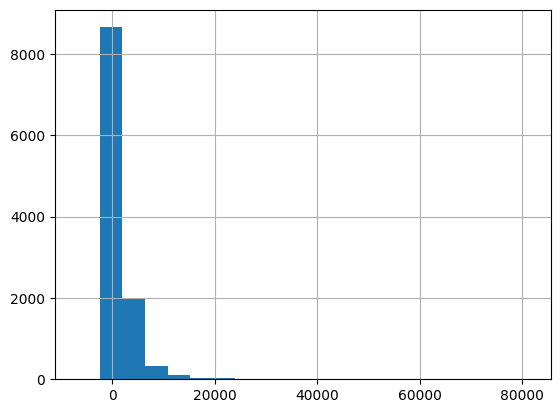

In [37]:
df['balance'].hist(bins=20)

count    11141.000000
mean      1529.583072
std       3227.835848
min      -6847.000000
25%        122.000000
50%        550.000000
75%       1709.000000
max      81204.000000
Name: balance, dtype: float64


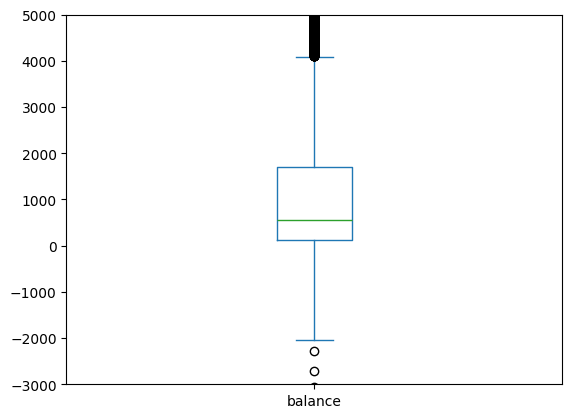

In [38]:
print(df['balance'].describe())
df['balance'].plot.box()
plt.ylim(-3000, 5000)
plt.show()

           count         mean          std     min    25%    50%     75%  \
default                                                                    
False    10973.0  1553.947690  3244.789130 -3058.0  132.0  564.0  1737.0   
True       168.0   -61.803571   827.742361 -6847.0 -344.0    0.0    65.5   

             max  
default           
False    81204.0  
True      5249.0  


<Axes: xlabel='balance', ylabel='Count'>

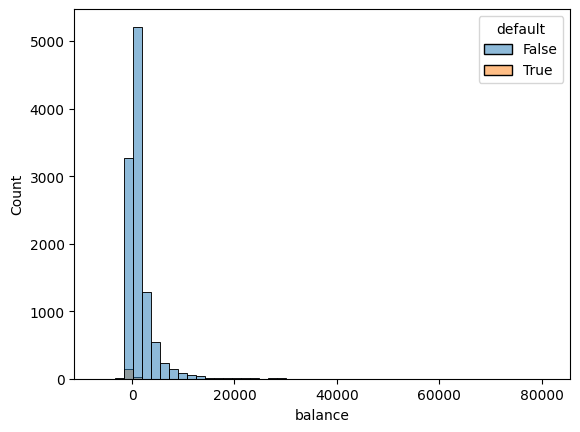

In [39]:
print(df.groupby('default')['balance'].describe())
sns.histplot(data=df, x='balance', hue='default', bins=50)

balance_group
0-500        3882
500-1500     2697
1500-5000    2332
Deute        1459
5000+         771
Name: count, dtype: int64


<Axes: xlabel='balance_group'>

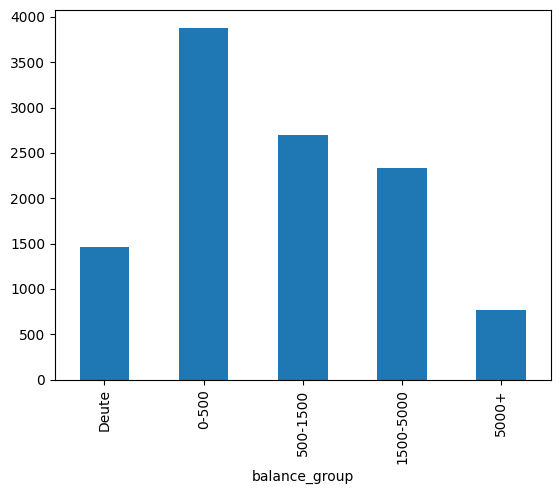

In [40]:
bins=[-7000, 0, 500, 1500, 5000, 82000]
labels=['Deute', '0-500', '500-1500', '1500-5000', '5000+']

df['balance_group'] = pd.cut(df['balance'],bins=bins, labels=labels)
print(df['balance_group'].value_counts())

df['balance_group'].value_counts().reindex(labels).plot.bar()

In [41]:
df.groupby('balance_group')['default'].value_counts()

C:\Users\maria\AppData\Local\Temp\ipykernel_336\4064366664.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('balance_group')['default'].value_counts()


balance_group  default
Deute          False      1356
               True        103
0-500          False      3831
               True         51
500-1500       False      2685
               True         12
1500-5000      False      2331
               True          1
5000+          False       770
               True          1
Name: count, dtype: int64

In [42]:
df['default'].value_counts(normalize=True)

default
False    0.984921
True     0.015079
Name: proportion, dtype: float64

In [43]:
print(round(df.groupby('default')['balance'].describe(), 2))

           count     mean      std     min    25%    50%     75%      max
default                                                                  
False    10973.0  1553.95  3244.79 -3058.0  132.0  564.0  1737.0  81204.0
True       168.0   -61.80   827.74 -6847.0 -344.0    0.0    65.5   5249.0


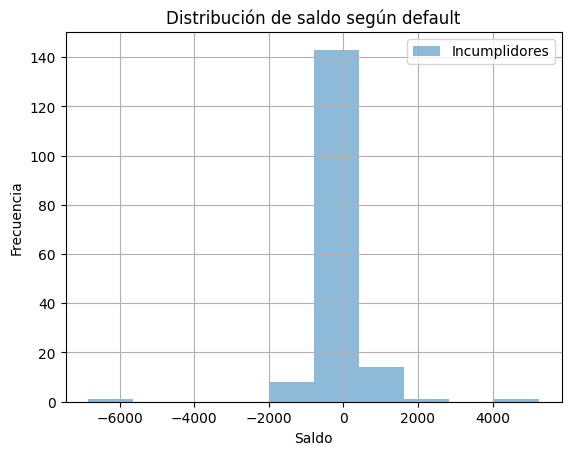

In [44]:
df[df['default'] == 1]['balance'].hist(alpha=0.5, label='Incumplidores')
#df[df['default'] == 0]['balance'].hist(alpha=0.5, label='Cumplidores')
plt.legend()
plt.title('Distribución de saldo según default')
plt.xlabel('Saldo')
plt.ylabel('Frecuencia')
plt.show()

### Para saber si son distribuciones normales --> Test de Shapiro-Wilk
- No son distribuciones normales

In [45]:
# Prueba de normalidad
    # Si p < 0.05 --> no es normal
saldo_incumplen = df[df['default'] == 1]['balance']
saldo_cumplen = df[df['default'] == 0]['balance']

stat_true, p_true = stats.shapiro(saldo_incumplen)
stat_false, p_false = stats.shapiro(saldo_cumplen)

print(f'Distribución de los que incumplen, Shapiro-Wilk: p={p_true}')  
print(f'Distribución de los que cumplen, Shapiro-Wilk: p={p_false}') 

Distribución de los que incumplen, Shapiro-Wilk: p=1.3038098569837037e-19
Distribución de los que cumplen, Shapiro-Wilk: p=8.01071921931186e-102


c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10973.
  res = hypotest_fun_out(*samples, **kwds)


### Tests estadísticos de comprobación de hipótesis

#### *Teoría*
**¿Qué hace este test de Student?**

**SIRVE PARA MUESTRAS QUE SIGUEN UNA DISTRIBUCIÓN NORMAL --> NO ME SIRVE EN ESTE CASO**

Evalúa la hipótesis nula (H₀):

> Las dos muestras (saldo_incumplen y saldo_cumplen) provienen de poblaciones con la misma media.

Contra la hipótesis alternativa (H₁):

> Las medias son diferentes (no necesariamente una mayor que la otra).

Resultado del test:

- t_stat: valor de la estadística t (cuánto difieren las medias en relación con la variabilidad de los datos).

- p_val: valor-p, que nos dice la probabilidad de observar una diferencia como la que vemos (o mayor) si en realidad las medias fueran iguales.

In [46]:
from scipy.stats import ttest_ind
"""Esta función realiza un test t de Student para muestras independientes, también conocido como test t de comparación de medias."""

saldo_incumplen = df[df['default'] == 1]['balance']
saldo_cumplen = df[df['default'] == 0]['balance']

"""Queremos comparar si las medias de estos dos grupos son estadísticamente diferentes."""

t_stat, p_val = ttest_ind(saldo_incumplen, saldo_cumplen, equal_var=False)
print(f"T-statistic: {t_stat:.2f}, P-value: {p_val:.6f}")

"""equal_var=False indica que no asumimos varianzas iguales entre los dos grupos."""

T-statistic: -22.76, P-value: 0.000000


'equal_var=False indica que no asumimos varianzas iguales entre los dos grupos.'

#### *Teoría 2*

### **¿Qué hace este test de Mann-Whitney U?**

**SIRVE PARA MUESTRAS QUE NO SIGUEN UNA DISTRIBUCIÓN NORMAL → SÍ ME SIRVE EN ESTE CASO**

Evalúa la hipótesis nula (H₀):

> Las dos muestras (saldo\_incumplen y saldo\_cumplen) provienen de la misma distribución (no hay diferencias en la tendencia central).

Contra la hipótesis alternativa (H₁):

> Las distribuciones son diferentes (una tiende a tener valores más altos o más bajos que la otra).

Resultado del test:

- U_stat: estadístico U, que mide cuántos valores de un grupo “superan” a los del otro en rango.

- p_val: valor-p, que nos dice la probabilidad de observar una diferencia en los rangos tan grande como la obtenida (o mayor) si las dos distribuciones fueran realmente iguales.


Este test no compara medias, sino **rangos**.
Es ideal cuando los datos están sesgados, tienen outliers o no son normales

In [47]:
# Aplicar la prueba de Mann-Whitney
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(saldo_incumplen, saldo_cumplen, alternative='two-sided')

print(f'Estadístico U: {stat}')
print(f'Valor p: {p}')

"""Como el valor p es extremadamente pequeño, rechazamos la hipótesis nula (H₀).
Esto indica que las distribuciones de saldo entre los que incumplen y los que no incumplen son significativamente diferentes.

Los clientes que incumplen tienden a tener saldos sistemáticamente más bajos que los que no incumplen.
Y esta diferencia no se debe al azar.

Analizamos los saldos disponibles de los clientes que cumplen con sus créditos y los que no. Queríamos saber si hay una diferencia real entre ambos grupos, o si lo que vemos es simplemente casualidad.

Usamos una prueba estadística diseñada para este tipo de situaciones, especialmente cuando los datos no se comportan de forma regular (es decir, no siguen una forma simétrica ni “normal”).

La diferencia entre los dos grupos es extremadamente significativa.
Los clientes que incumplen tienden a tener saldos mucho más bajos que los que sí cumplen, y esta diferencia no es por azar ni por coincidencia."""

Estadístico U: 276024.5
Valor p: 6.234407826081674e-55


'Como el valor p es extremadamente pequeño, rechazamos la hipótesis nula (H₀).\nEsto indica que las distribuciones de saldo entre los que incumplen y los que no incumplen son significativamente diferentes.\n\nLos clientes que incumplen tienden a tener saldos sistemáticamente más bajos que los que no incumplen.\nY esta diferencia no se debe al azar.\n\nAnalizamos los saldos disponibles de los clientes que cumplen con sus créditos y los que no. Queríamos saber si hay una diferencia real entre ambos grupos, o si lo que vemos es simplemente casualidad.\n\nUsamos una prueba estadística diseñada para este tipo de situaciones, especialmente cuando los datos no se comportan de forma regular (es decir, no siguen una forma simétrica ni “normal”).\n\nLa diferencia entre los dos grupos es extremadamente significativa.\nLos clientes que incumplen tienden a tener saldos mucho más bajos que los que sí cumplen, y esta diferencia no es por azar ni por coincidencia.'

**Preguntas**

1. ¿Hay evidencia clara de que el riesgo de incumplimiento es más alto con saldos bajos?

2. ¿Cómo varía el riesgo entre los diferentes deciles?

3. ¿La diferencia es estadísticamente significativa?

**Resultados**
- El valor-p es muchísimo menor que 0.05 (p = 6.23e-55), lo que nos permite rechazar la hipótesis nula con total seguridad.
- El estadístico U fue de 276024.5, lo cual, junto con el valor-p, indica que las distribuciones de saldo entre clientes que incumplen y los que no, son significativamente diferentes.
- La mediana del saldo de los clientes que incumplen es claramente más baja, lo que refuerza la idea de que hay una asociación entre bajo saldo y mayor riesgo de impago.
*Sí, los clientes con saldos más bajos tienden a incumplir más el crédito*

**Respuestas**
1. Sí, existe evidencia clara. La prueba de Mann-Whitney U dio un estadístico U = 276024.5 con un p-valor extremadamente bajo, p-valor < 0.000001, lo que indica que la diferencia entre las distribuciones de saldo es significativa. Esto sugiere que los clientes que incumplen tienden a tener saldos más bajos.

2. Variación del riesgo entre deciles:
    - El riesgo disminuye a medida que aumenta el decil de saldo.
    - Los 3 primeros deciles (saldos más bajos) concentran la mayoría de los incumplimientos.
    - A partir del decil 5 la tasa de riesgo es mínima (< 0.3 %)

3. Sí, la diferencia es estadísticamente significativa. Aunque el test de Mann-Whitney no compara medias sino rangos y distribuciones, el resultado confirma que los saldos de quienes incumplen tienden a ser más bajos que los de quienes cumplen.

#### Probabilidad de incumplimiento (PD)

In [48]:
pd_global = df['default'].mean()
print("PD global =", round(pd_global*100, 2), "%")

PD global = 1.51 %


### Analisis Fabio
 hice el analisis por percentiles a ver que te parece, lo agregue a tu script para que lo puedas correr y ya dejamos este archivo como definitivo sobre el que vamos a trabajar.
 En este ya uso df ( osea el limpio ) y no el original por lo que ya lo puse en el repositorio

Tasa de incumplimiento por decil de saldo:
   balance_decile  default
0               1   0.0706
1               2   0.0284
2               3   0.0135
3               4   0.0089
4               5   0.0036
5               6   0.0027
6               7   0.0072
7               8   0.0009
8               9   0.0009
9              10   0.0009


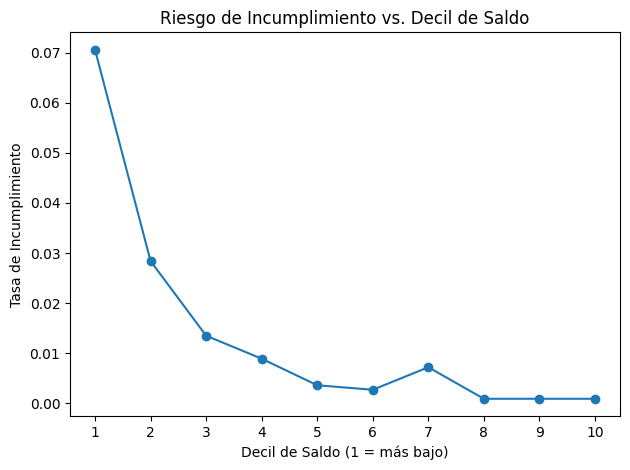

Decil 1: (-6847.001, 0.0]
Decil 2: (0.0, 62.0]
Decil 3: (62.0, 189.0]
Decil 4: (189.0, 337.0]
Decil 5: (337.0, 550.0]
Decil 6: (550.0, 863.0]
Decil 7: (863.0, 1341.0]
Decil 8: (1341.0, 2225.0]
Decil 9: (2225.0, 3899.0]
Decil 10: (3899.0, 81204.0]


In [49]:
df = pd.read_csv("../Data/df.csv")

#  Crear deciles de balance para agrupar clientes en 10 grupos iguales
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False)

# Calcular la tasa de incumplimiento (default) por cada decil
default_rates = (df.groupby('balance_decile')['default'].mean().reset_index()) #la media aritmética en ese grupo equivale a la proporción (o tasa) de incumplimiento
default_rates['default'] = default_rates['default'].round(4) 
default_rates['balance_decile'] = default_rates['balance_decile'] + 1

#  Mostrar resultados en consola
print("Tasa de incumplimiento por decil de saldo:")
print(default_rates)

#  Graficar la relación
plt.figure()
plt.plot(default_rates['balance_decile'], default_rates['default'], marker='o')
plt.xlabel('Decil de Saldo (1 = más bajo)')
plt.ylabel('Tasa de Incumplimiento')
plt.title('Riesgo de Incumplimiento vs. Decil de Saldo')
plt.xticks(range(1, 11))
plt.tight_layout()
plt.show()

# Crear los bins explícitamente con qcut
df['balance_decile_range'] = pd.qcut(df['balance'], q=10)

# Obtener los intervalos únicos en orden
balance_ranges = df['balance_decile_range'].cat.categories

# Mostrar los rangos de cada decil
for i, r in enumerate(balance_ranges, start=1):
    print(f"Decil {i}: {r}")

#### Aqui calculo un indice de riesgo por cada decil para darnos una idea del riesgo contra el riesgo medio para apartir de este determinar un umbral de riesgo

In [30]:
# Calcular tasa global de incumplimiento
Tasa_global_impagos = df['default'].mean()
print(f"Tasa global de incumplimiento: {Tasa_global_impagos:.4f}")
# Calculamos el indice de riesgo por decil riesgo/riesgo global
default_rates['indice_riesgo'] = default_rates['default'] / Tasa_global_impagos
default_rates['indice_riesgo'] = default_rates['indice_riesgo'].round(2)
print(default_rates)

Tasa global de incumplimiento: 0.0151
   balance_decile  default  indice_riesgo
0               1   0.0706           4.68
1               2   0.0284           1.88
2               3   0.0135           0.90
3               4   0.0089           0.59
4               5   0.0036           0.24
5               6   0.0027           0.18
6               7   0.0072           0.48
7               8   0.0009           0.06
8               9   0.0009           0.06
9              10   0.0009           0.06


In [58]:
"""Añado la cantidad de clientes en cada decil"""

clientes_por_decil = df['balance_decile'].value_counts().sort_index()
clientes_totales = len(df)

clientes_stats = pd.DataFrame({
    'balance_decile': clientes_por_decil.index,
    'clientes': clientes_por_decil.values,
    'porcentaje_clientes': np.round((clientes_por_decil.values / clientes_totales * 100), 2)
})

default_rates_clients = default_rates.merge(clientes_stats, on='balance_decile')
default_rates_clients


,balance_decile,default,clientes,porcentaje_clientes
0,1,0.0706,776,6.97
1,2,0.0284,1108,9.95
2,3,0.0135,1118,10.04
3,4,0.0089,1113,9.99
4,5,0.0036,1115,10.01
5,6,0.0027,1110,9.96
6,7,0.0072,1114,10.00
7,8,0.0009,1114,10.00
8,9,0.0009,1114,10.00


### Visualización un poco mas completa ya incorporando un umbral de riesgo
**Fuente**: Elaboración propia basada en prácticas comunes del sector bancario para productos de crédito revolvente, con referencias a datos de morosidad publicados por el Federal Reserve Bank of New York y lineamientos de Basilea II/III para segmentación de riesgo retail.

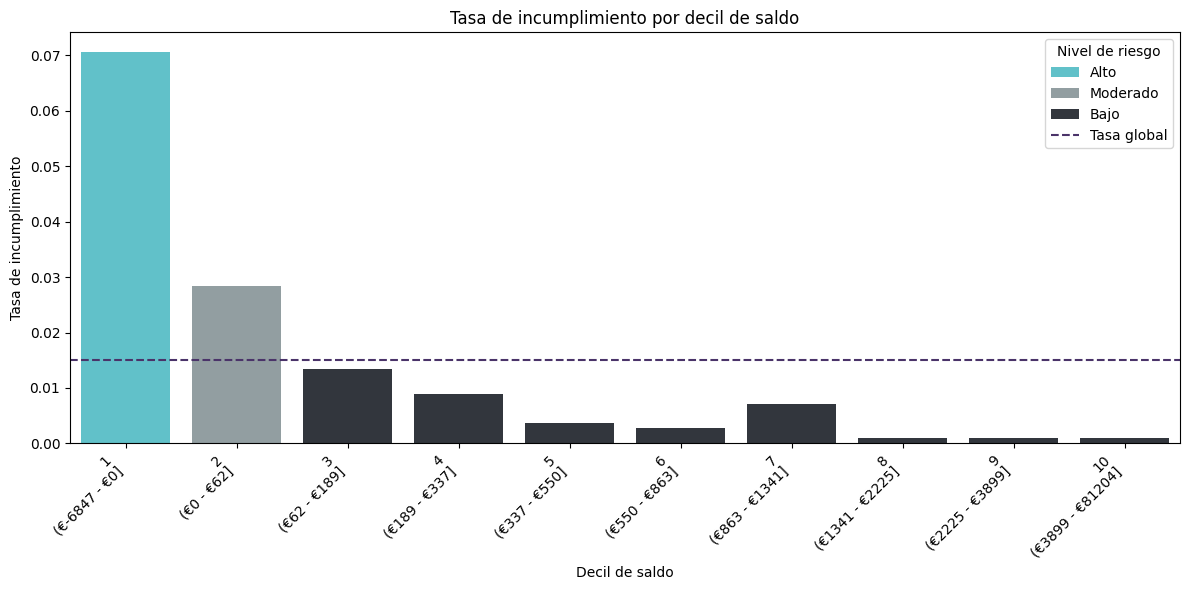

In [59]:
def categorize_risk(rate):
    if rate > 0.10:
        return 'Muy alto'
    elif rate > 0.05:
        return 'Alto'
    elif rate > 0.02:
        return 'Moderado'
    else:
        return 'Bajo'
    
#  Definir colores personalizados para cada nivel de riesgo
color_map = {
    'Muy alto': '#4A3369',     
    'Alto': '#4FD0DB',         
    'Moderado': '#8FA0A3',     
    'Bajo': '#30353F'          
}

# Crear una lista de etiquetas con número de decil y su rango
decile_labels = [
    f"{i+1}\n(€{int(interval.left)} - €{int(interval.right)}]"
    for i, interval in enumerate(balance_ranges)
]

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rates, x='balance_decile', y='default', hue='risk_level', palette=color_map)
plt.axhline(Tasa_global_impagos, color='#4A3369', linestyle='--', label='Tasa global')
plt.xticks(ticks=range(10), labels=decile_labels, rotation=45, ha='right')
plt.title('Tasa de incumplimiento por decil de saldo')
plt.xlabel('Decil de saldo')
plt.ylabel('Tasa de incumplimiento')
plt.legend(title='Nivel de riesgo')
plt.tight_layout()
plt.savefig('../Results/tasa_incumplimiento_deciles.png', dpi=300)
plt.show()

In [65]:
"""Añado porcentaje de clientes por categoría de riesgo"""
default_rates_clients['risk_level'] = default_rates_clients['default'].apply(categorize_risk)

porcentaje_riesgo = default_rates_clients.groupby('risk_level')['porcentaje_clientes'].sum().reset_index()

orden = ['Muy alto', 'Alto', 'Moderado', 'Bajo']
porcentaje_riesgo['risk_level'] = pd.Categorical(porcentaje_riesgo['risk_level'], categories=orden, ordered=True)
porcentaje_riesgo = porcentaje_riesgo.sort_values('risk_level')
porcentaje_riesgo

,risk_level,porcentaje_clientes
0,Alto,6.97
2,Moderado,9.95
1,Bajo,70.00
